#### [ 로지스틱, KNN기반 분류 모델 - 생존자 분류 ]
- 데이터셋 : titanic.csv
- 주제 : 생존자분류
- 타겟 : Survived
- 피쳐 : 선별.
- 학습종류 : 지도학습 /분류
- 알고리즘 : 로지스틱, KNN 기반 분류진행

In [211]:
## 1-1
import pandas as pd
# 데이터 분석 및 전처리
import numpy as np
# 숫자처리
import matplotlib.pyplot as plt
# 데이터 시각화
from sklearn.neighbors import KNeighborsRegressor
                                #knn
from sklearn.linear_model import LinearRegression, LogisticRegression
                            ## ML 알고리즘
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
                            ## 성능평가 모듈
from sklearn.model_selection import train_test_split
                            ## 데이터셋 분리 관련 모듈
                            ## 학습/검증/테스트 
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
                            ## 정규화, 컬럼추가
                            

#### [1] 데이터 준비 및 확인

PassengerId	승객의 고유 ID<br>
Survived	생존 여부 (0 = 사망, 1 = 생존)<br>
Pclass	티켓 등급 (1 = 1등석, 2 = 2등석, 3 = 3등석)<br>
Name	승객의 이름<br>
Sex	성별 (male, female)<br>
Age	나이 (일부 결측값 존재)<br>
SibSp	함께 탑승한 형제자매 및 배우자의 수<br>
Parch	함께 탑승한 부모 및 자녀의 수<br>
Ticket	티켓 번호<br>
Fare	운임 요금<br>
Cabin	선실 번호 (일부 결측값 존재)<br>
Embarked 탑승한 항구

In [212]:
originDF = pd.DataFrame(pd.read_csv('../data/train.csv', index_col='PassengerId'))
originDF.info()
originDF.head()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터 분석
- Name은 변별력이 없음. 
- Ticket과 Pclass간 관계, 같은 티켓을 사용한 사용자간 관계 추측.
- Cabin -> 결측값 다수. 티켓 및 fare로 추측하기.

In [213]:
tList = originDF['Ticket'].unique()

originDF["Cabin"] =originDF.groupby('Ticket')['Cabin'].transform(lambda x: x.ffill().bfill())

C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\3050342373.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  originDF["Cabin"] =originDF.groupby('Ticket')['Cabin'].transform(lambda x: x.ffill().bfill())


In [214]:
originDF[originDF['Embarked'].isna()]['Embarked']
originDF.loc[62,'Embarked'] = 'S'
originDF.loc[830,'Embarked'] = 'S'

In [215]:
originDF['Embarked'].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [216]:
originDF[originDF['Age'].isna()].loc[(originDF['SibSp']==0) & (originDF['Parch']==0)  & (originDF['Name'].str.contains('Dr')) ]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.75,NaN,Q
767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.60,NaN,C


In [217]:
originDF.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       676
Embarked      0
dtype: int64

In [218]:
originDF = originDF.drop(index=originDF[originDF['Fare']>300].index)

In [219]:
#  3179//182
midx = originDF[(originDF['Name'].str.contains('Miss') & (originDF['Age'].isna()))]['Age'].index

originDF.loc[midx,'Age'] = 3179//182


In [220]:
mrsidx = originDF[(originDF['Name'].str.contains('Mrs') & (originDF['Age'].isna()))]['Age'].index

originDF.loc[mrsidx,'Age'] = 3992//129

In [221]:
titles = [
    "Mr.", "Mrs.", "Miss.", "Master.", "Dr.", 
    "Rev.", "Col.", "Major.", "Sir.", "Lady.", 
    "Countess.", "Ms.", "Mlle.", "Mme.", "Dr. Mrs."
]
for i in titles:
    if originDF[(originDF['Name'].str.contains(i) & (originDF['Age'].isna()))].index.any():
        a = originDF[(originDF['Name'].str.contains(i))]['Age'].shape
        b = originDF[(originDF['Name'].str.contains(i))]['Age'].sum()
        print(i, a,b,b//a)
        nullindex = originDF[(originDF['Name'].str.contains(i) & (originDF['Age'].isna()))]['Age'].index
    originDF.loc[nullindex,'Age'] =4

Mr. (645,) 17362.5 [26.]
Master. (40,) 164.67000000000002 [4.]
Dr. (10,) 336.0 [33.]


In [222]:
originDF[originDF['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


In [223]:
originDF.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       676
Embarked      0
dtype: int64

Cabin 컬럼은 빈값이 너무 많아 채우더라도 진실성이 의심됨. 폐기
label 필요 컬럼
Sex, Age, Fare, Embarked

In [224]:
# originDF.to_csv('titanic_prepro.csv', encoding='utf-8')

In [225]:
originDF.drop(columns='Cabin',inplace=True)

In [226]:
## male = 0 , female = 1
originDF['Sex'] = originDF['Sex'].map({'male': 1, 'female':0})
originDF['Sex'] = originDF['Sex'].astype('int')
originDF['Sex'].value_counts()

Sex
1    575
0    313
Name: count, dtype: int64

In [227]:
originDF['Age'].max()

80.0

In [228]:
bins = [0, 18, 29, 39, 49, 59, 100]
labels = ['18-', '18-29', '30-39', '40-49', '50-59', '60+']

originDF['AgeCut'] = pd.cut(originDF['Age'], bins=bins, labels=labels)
originDF['AgeCut'].value_counts()

AgeCut
18-      299
18-29    245
30-39    181
40-49     89
50-59     48
60+       26
Name: count, dtype: int64

In [229]:
bins = [-1,10,20,30,40,50,100,300]
labels=[10,20,30,40,50,100,300]
originDF['Fare_under'] = pd.cut(originDF['Fare'], bins=bins, labels=labels)
for i in originDF['Embarked'].unique():
    
    print(i, pd.cut(originDF[(originDF['Embarked']==i)]['Fare'], bins=bins, labels=labels).value_counts())
    
# plt.hist(pd.cut(originDF['Fare'], bins=bins, labels=labels))

S Fare
10     245
20     135
30     115
100     73
40      45
300     24
50       9
Name: count, dtype: int64
C Fare
10     37
20     33
100    32
300    26
30     17
40     13
50      7
Name: count, dtype: int64
Q Fare
10     54
20     11
30     10
100     2
40      0
50      0
300     0
Name: count, dtype: int64


In [230]:
type(originDF.value_counts())

pandas.core.series.Series

In [231]:
for i in originDF['Embarked'].unique():
    print(i, originDF.loc[(originDF['Embarked']==i),['Fare_under', 'Survived']].sort_values('Fare_under').groupby('Fare_under').value_counts())

S Fare_under  Survived
10          0           208
            1            37
20          0            82
            1            53
30          0            62
            1            53
40          0            29
            1            16
50          0             9
            1             0
100         1            42
            0            31
300         1            18
            0             6
Name: count, dtype: int64
C Fare_under  Survived
10          0           28
            1            9
20          1           18
            0           15
30          0           10
            1            7
40          1            7
            0            6
50          1            4
            0            3
100         1           27
            0            5
300         1           18
            0            8
Name: count, dtype: int64
Q Fare_under  Survived
10          0           33
            1           21
20          0            6
            1            5
3

C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\3669145051.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(i, originDF.loc[(originDF['Embarked']==i),['Fare_under', 'Survived']].sort_values('Fare_under').groupby('Fare_under').value_counts())
C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\3669145051.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(i, originDF.loc[(originDF['Embarked']==i),['Fare_under', 'Survived']].sort_values('Fare_under').groupby('Fare_under').value_counts())
C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\3669145051.py:2: FutureWarning: The default of observed=False is depr

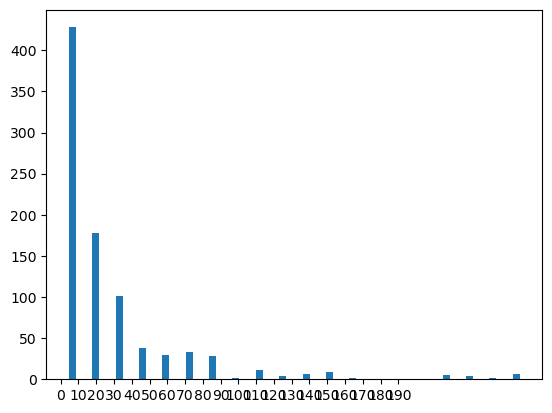

In [232]:
plt.hist(originDF['Fare'],bins=20, rwidth=0.3)
plt.xticks(list(range(0,200,10)))
plt.show()


In [233]:
originDF['Embarked'].unique()
originDF['Embarked_num'] = originDF['Embarked'].map({'S':0, 'C':1, 'Q':2})

##### 2. KNN
- 타겟컬럼 : Survived.


In [234]:
from _utils import tools as ts
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [235]:
encoder = OneHotEncoder()
# 대상 컬럼
# Sex, Embarked.

In [236]:
originDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 1 to 891
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      888 non-null    int64   
 1   Pclass        888 non-null    int64   
 2   Name          888 non-null    object  
 3   Sex           888 non-null    int64   
 4   Age           888 non-null    float64 
 5   SibSp         888 non-null    int64   
 6   Parch         888 non-null    int64   
 7   Ticket        888 non-null    object  
 8   Fare          888 non-null    float64 
 9   Embarked      888 non-null    object  
 10  AgeCut        888 non-null    category
 11  Fare_under    888 non-null    category
 12  Embarked_num  888 non-null    int64   
dtypes: category(2), float64(2), int64(6), object(3)
memory usage: 117.8+ KB


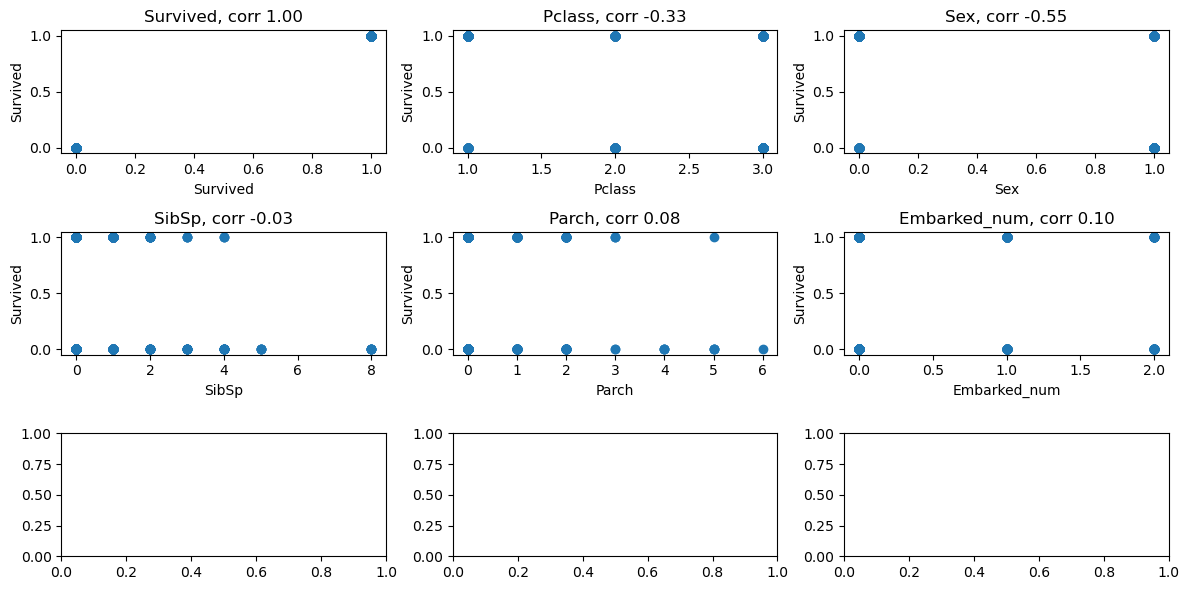

In [237]:
ts.plot_corr(originDF,originDF.columns[[0,1,3,5,6,12]],originDF.columns[0])

In [238]:
for i in originDF['Embarked'].unique():

    print(i, originDF.loc[(originDF['Embarked']==i),['AgeCut', 'Survived']].sort_values('AgeCut').groupby('AgeCut').value_counts())

S AgeCut  Survived
18-     0           129
        1            57
18-29   0           140
        1            59
30-39   0            77
        1            62
40-49   0            46
        1            23
50-59   0            21
        1            13
60+     0            14
        1             5
Name: count, dtype: int64
C AgeCut  Survived
18-     0           30
        1           27
18-29   1           24
        0           15
30-39   1           19
        0           15
40-49   1           11
        0            6
50-59   1            7
        0            6
60+     0            3
        1            2
Name: count, dtype: int64
Q AgeCut  Survived
18-     0           32
        1           24
18-29   0            4
        1            3
30-39   0            5
        1            3
40-49   0            3
        1            0
50-59   0            1
        1            0
60+     0            2
        1            0
Name: count, dtype: int64


C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\2064619080.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(i, originDF.loc[(originDF['Embarked']==i),['AgeCut', 'Survived']].sort_values('AgeCut').groupby('AgeCut').value_counts())
C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\2064619080.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(i, originDF.loc[(originDF['Embarked']==i),['AgeCut', 'Survived']].sort_values('AgeCut').groupby('AgeCut').value_counts())
C:\Users\kdt\AppData\Local\Temp\ipykernel_5916\2064619080.py:3: FutureWarning: The default of observed=False is deprecated and will be chang

In [239]:
originDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 1 to 891
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      888 non-null    int64   
 1   Pclass        888 non-null    int64   
 2   Name          888 non-null    object  
 3   Sex           888 non-null    int64   
 4   Age           888 non-null    float64 
 5   SibSp         888 non-null    int64   
 6   Parch         888 non-null    int64   
 7   Ticket        888 non-null    object  
 8   Fare          888 non-null    float64 
 9   Embarked      888 non-null    object  
 10  AgeCut        888 non-null    category
 11  Fare_under    888 non-null    category
 12  Embarked_num  888 non-null    int64   
dtypes: category(2), float64(2), int64(6), object(3)
memory usage: 117.8+ KB


In [240]:
## agecut, fareunder . 라벨인코더해야됨
acLabel = LabelEncoder()
originDF['AgeLabel']=acLabel.fit_transform(originDF['AgeCut'])

fuLabel = LabelEncoder()
originDF['FuLabel']=fuLabel.fit_transform(originDF['Fare_under'])

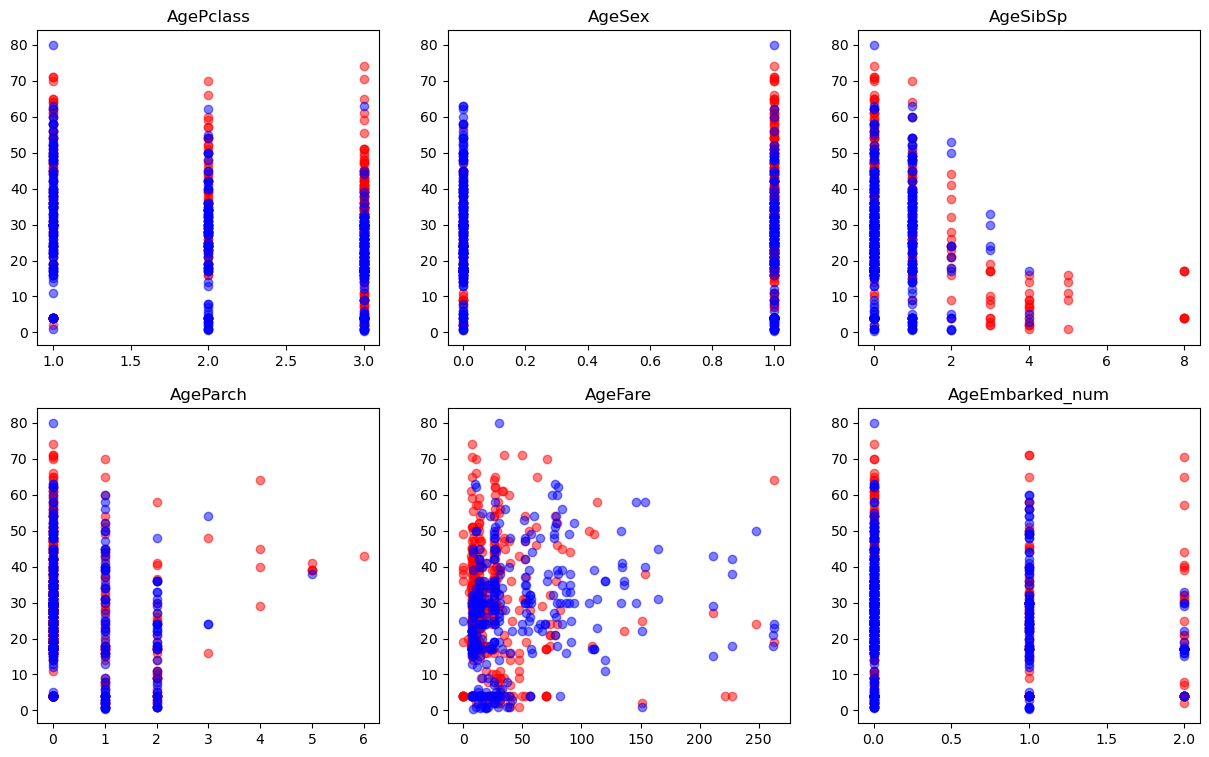

In [241]:
# [1, 3, 4, 5, 6, 8, 12]
fig, axe = plt.subplots(2,3, figsize=(15,9))
axe = axe.flatten()
target = 'Age'
colnum = [1, 3, 5, 6, 8, 12]

dead = originDF[originDF['Survived']==0]
live  = originDF[originDF['Survived']==1]
# print(originDF.columns[colnum])
# print(dead[target])
for ax, i in zip(axe,originDF.columns[colnum]):
    ax.plot(dead[i], dead[target], 'or', alpha=0.5)
    ax.plot(live[i], live[target], 'ob', alpha=0.5)
    ax.set_title(target+i)

In [242]:
originDF['Survived'].corr(originDF['Age'])

np.float64(0.043769310252116916)

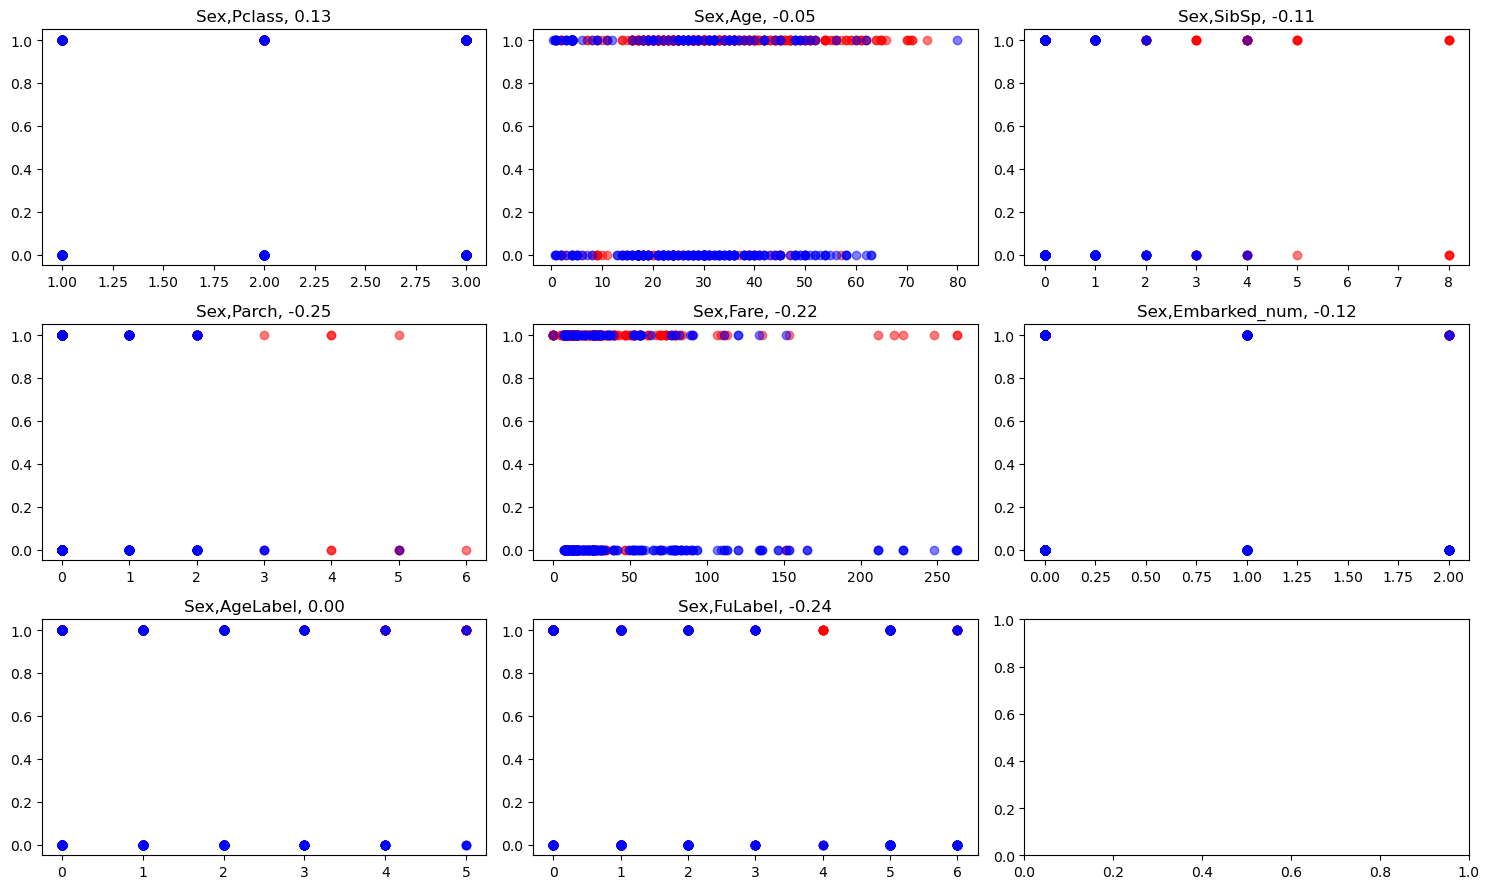

In [243]:
# [1, 3, 4, 5, 6, 8, 12]
fig, axe = plt.subplots(3,3, figsize=(15,9))
axe = axe.flatten()
target = 'Sex'
colnum = [1, 4, 5, 6, 8, 12,13,14]

dead = originDF[originDF['Survived']==0]
live  = originDF[originDF['Survived']==1]
# print(originDF.columns[colnum])
# print(dead[target])
for ax, i in zip(axe,originDF.columns[colnum]):
    ax.plot(dead[i], dead[target], 'or', alpha=0.5)
    ax.plot(live[i], live[target], 'ob', alpha=0.5)
    ax.set_title(f"{target},{i}, {originDF[target].corr(originDF[i]):.2f}")
                 
plt.tight_layout()
plt.show()

In [244]:
originDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 1 to 891
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      888 non-null    int64   
 1   Pclass        888 non-null    int64   
 2   Name          888 non-null    object  
 3   Sex           888 non-null    int64   
 4   Age           888 non-null    float64 
 5   SibSp         888 non-null    int64   
 6   Parch         888 non-null    int64   
 7   Ticket        888 non-null    object  
 8   Fare          888 non-null    float64 
 9   Embarked      888 non-null    object  
 10  AgeCut        888 non-null    category
 11  Fare_under    888 non-null    category
 12  Embarked_num  888 non-null    int64   
 13  AgeLabel      888 non-null    int64   
 14  FuLabel       888 non-null    int64   
dtypes: category(2), float64(2), int64(8), object(3)
memory usage: 131.7+ KB


In [265]:
featureDF = originDF[originDF.columns[[1, 3, 13, 14]]]
classDF = originDF['Survived']
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (888, 4)  classDF : (888,)


In [266]:
## - 회귀가 아니고 분류 시행시에는
## 훈련용이랑 테스트용에 동일한 비율로 
## 타겟이 배분되어야 한다.
## setosa : versi = 5:5
#  ==> stratify 매개변수: 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리.
# pytorch엔 없음.

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    

train_X => 2D (710, 4) / test_X => 2D, (178, 4)
train_y => 1D (710,), / test_y => 1D, (178,)


In [267]:
## 데이터셋별로 클래스 갯수 확인
test_y.value_counts(), train_y.value_counts()

(Survived
 0    110
 1     68
 Name: count, dtype: int64,
 Survived
 0    439
 1    271
 Name: count, dtype: int64)

In [268]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = StandardScaler()

scaler.fit(train_X)

StandardScaler()

In [269]:
## fit() 후에 설정되는 파라미터들 ==> 모델 파라미터 . abd_
## 후행.

print(scaler.var_, scaler.mean_, scaler.feature_names_in_)

[0.701704027  0.2277107717 1.7921940091 3.9304185677] [2.3112676056 0.6492957746 1.3450704225 1.7830985915] ['Pclass' 'Sex' 'AgeLabel' 'FuLabel']


In [270]:
train_scaled_X = scaler.transform(train_X)
test_scaled_X = scaler.transform(test_X)

#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : 선형모델 로지스틱회귀

In [271]:
from sklearn.neighbors import KNeighborsClassifier

In [272]:
# 학습 진행 ==> 훈련용 데이터 진행 fit(2D, 1D)
knnClassifer = KNeighborsClassifier()
knnClassifer.fit(train_scaled_X, train_y)

KNeighborsClassifier()

In [275]:
# 분류모델 성능 체크 ==> 정확도 accuracy 가 성능체크로 사용됨
#train_X, test_X, train_y, test_y

score_test1 = knnClassifer.score(test_X, test_y)
score_test2 = knnClassifer.score(train_X, train_y)
score_test2, score_test1

c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


(0.6676056338028169, 0.5842696629213483)

[6] 성능지표 평가<hr>


In [276]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score


In [277]:
## 예측값 계산
pre_ = knnClassifer.predict(test_X)
precision = precision_score(test_y, pre_)
recall = recall_score(test_y,pre_)
f1 = f1_score(test_y,pre_)

print(pre_, precision, recall, f1)

[1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0] 0.45 0.39705882352941174 0.421875


c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [278]:
## 분류성능평가 보고서
classification_report(test_y, pre_,output_dict=True)

{'0': {'precision': 0.652542372881356,
  'recall': 0.7,
  'f1-score': 0.6754385964912281,
  'support': 110.0},
 '1': {'precision': 0.45,
  'recall': 0.39705882352941174,
  'f1-score': 0.421875,
  'support': 68.0},
 'accuracy': 0.5842696629213483,
 'macro avg': {'precision': 0.551271186440678,
  'recall': 0.5485294117647058,
  'f1-score': 0.5486567982456141,
  'support': 178.0},
 'weighted avg': {'precision': 0.5751666349266807,
  'recall': 0.5842696629213483,
  'f1-score': 0.5785716045732308,
  'support': 178.0}}

In [279]:
confusion_matrix(test_y,pre_)

array([[77, 33],
       [41, 27]])

[7] 예측 및 시각화 <hr>

In [ ]:
train_X.head()


array([[ 0.8221925286,  0.7349354746, -1.0047372696,  0.1094064612],
       [ 0.8221925286,  0.7349354746, -0.2577598231, -0.8994063627],
       [ 0.8221925286,  0.7349354746, -1.0047372696, -0.8994063627],
       [ 0.8221925286,  0.7349354746, -1.0047372696, -0.3949999507],
       [-1.5653604174,  0.7349354746,  0.4892176234,  1.6226256969]])

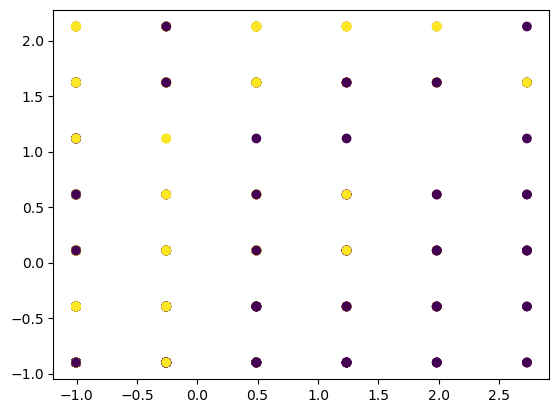

In [314]:
# 0 - pclass / 1 - sex / 2 - AgeLabel / 3 - FareLabel
# plt.scatter(train_scaled_X[:,0],train_scaled_X[:,1],train_scaled_X[:,2],train_scaled_X[:,3], c=train_y)
plt.scatter(train_scaled_X[:,2],train_scaled_X[:,3], c=train_y)
# plt.scatter(train_scaled_X[:,0],train_scaled_X[:,1], c=train_y)


plt.show()

In [290]:
train_scaled_X, train_y

(array([[ 0.8221925286,  0.7349354746, -1.0047372696,  0.1094064612],
        [ 0.8221925286,  0.7349354746, -0.2577598231, -0.8994063627],
        [ 0.8221925286,  0.7349354746, -1.0047372696, -0.8994063627],
        ...,
        [ 0.8221925286,  0.7349354746, -1.0047372696,  0.6138128731],
        [ 0.8221925286, -1.3606636699, -0.2577598231, -0.8994063627],
        [ 0.8221925286,  0.7349354746, -0.2577598231, -0.8994063627]]),
 PassengerId
 518    0
 90     0
 46     0
 126    1
 138    0
       ..
 610    1
 447    1
 851    0
 101    0
 128    1
 Name: Survived, Length: 710, dtype: int64)

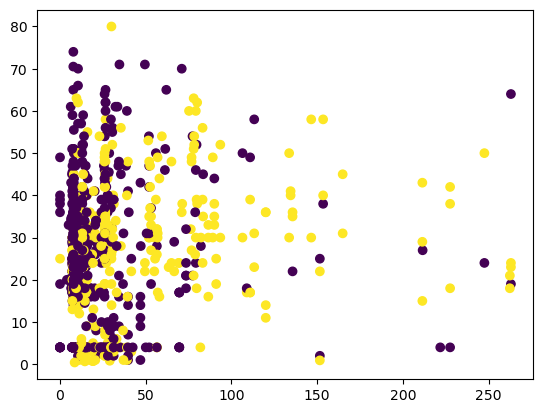

In [288]:
plt.scatter(originDF['Fare'],originDF['Age'], c=originDF['Survived'])


plt.show()

In [302]:
type(test_scaled_X), type(train_y)

(numpy.ndarray, pandas.core.series.Series)

In [304]:
new_data = np.array([[ 0.8221925286,  0.7349354746, -1.0047372696,  0.1094064612]])

## 예측하기 스칼라 반환-> 0차원. item()메소드로 값 추출가능.
pre_new_data = knnClassifer.predict(new_data)
# knnClassifer.classes_

# labelEn.classes_[pre_new_data].item()

In [305]:
pre_new_data

array([0])